In [26]:
import json

with open('new_all_qguide_data.html', 'r') as file:
    json_data = json.load(file)

with open('new_all_qguide_data.json', 'w') as file:
    json.dump(json_data, file, separators=(',', ':'))


In [37]:
# from bs4 import BeautifulSoup
# import pandas as pd
# import requests
# from tabulate import tabulate

# def extract_table_data(url):
#     # Fetch the HTML content from the URL
#     response = requests.get(url)
#     html = response.text

#     # Parse the HTML
#     soup = BeautifulSoup(html, 'html.parser')

#     # Define table names
#     table_names = ['Responses', 'General', 'Instructor', 'Hours', 'Recommendation', 'Recommendation_stats', 'Reasons', 'Will_tochange', 'Open_mind', 'Comments']

#     # Find all tables containing the required data
#     tables = soup.find_all('table')

#     # Create a dictionary to store DataFrames for each table
#     dataframes = {}

#     # Iterate through each table
#     for idx, table in enumerate(tables):
#         # Extract headers
#         headers = []
#         for th in table.find('tr').find_all('th'):
#             headers.append(th.text.strip())

#         # Extract data rows
#         data = []
#         for row in table.find_all('tr'):
#             row_data = [cell.text.strip() for cell in row.find_all(['td', 'th'])]
#             if len(row_data) == len(headers):
#                 data.append(row_data)

#         # If data rows exist
#         if len(data) > 1:
#             # Create a DataFrame excluding the header row
#             df = pd.DataFrame(data[1:], columns=headers)
#             dataframes[table_names[idx]] = df

#     return dataframes


In [59]:
from bs4 import BeautifulSoup
import pandas as pd
import requests

def extract_table_data(url):
    response = requests.get(url)
    html = response.text

    soup = BeautifulSoup(html, 'html.parser')

    # THIS PROBABLY IS BAD LONG-TERM BUT I"M FUCKING ANNOYED
    captions_to_skip = [
        "Table for [QTitle]-In this course, most students listen attentively with an open mind and a willingness to change their point of view as they learn more about the topic.-Statistics.",
        "Table for [QTitle]-In this course (including sections), I feel comfortable expressing my views on controversial topics.-Statistics.",
        "Table for [qtitle]-in this course, most students listen attentively with an open mind and a willingness to change their point of view as they learn more about the topic..",
        "Table for [qtitle]-in this course (including sections), i feel comfortable expressing my views on controversial topics..",
        "Table for [qtitle]-in this course, most students listen attentively with an open mind and a willingness to change their point of view as they learn more about the topic..",
    ]

    captions_to_skip = [caption.lower().strip() for caption in captions_to_skip]

    tables = soup.find_all('table')

    dataframes = {}

    table_index = 0

    for table in tables:
        caption_tag = table.find('caption')
        
        if caption_tag:
            caption_text = caption_tag.text.strip().lower()
            
            if any(skip_caption in caption_text for skip_caption in captions_to_skip):
                continue

        headers = [th.text.strip() for th in table.find('tr').find_all('th')]

        data = []
        for row in table.find_all('tr'):
            row_data = [cell.text.strip() for cell in row.find_all(['td', 'th'])]
            if len(row_data) == len(headers):
                data.append(row_data)

        if len(data) > 1:
            df = pd.DataFrame(data[1:], columns=headers)
            dataframes[f'Table_{table_index}'] = df
            table_index += 1

    return dataframes


In [60]:
# Example usage:
url = "https://harvard.bluera.com/harvard/rpv-eng.aspx?lang=eng&redi=1&SelectedIDforPrint=2a25bbb354dd26d2a5018145b3eccac802438e93cb86651665bfd7dc8f5e8b888dcf958e60eb641327093338906fe195&ReportType=2&regl=en-US"
tables_data = extract_table_data(url)

# Print each table with its name
for table_name, table_df in tables_data.items():
    print(f"Table '{table_name}':")
    print(tabulate(table_df, headers='keys', tablefmt='grid'))
    print()

Table 'Table_0':
+----+----------------+------------+
|    | Raters         | Students   |
+====+================+============+
|  0 | Responded      | 5          |
+----+----------------+------------+
|  1 | Invited        | 7          |
+----+----------------+------------+
|  2 | Response Ratio | 71%        |
+----+----------------+------------+

Table 'Table_1':
+----+--------------------------------------------------------------------------------------------+---------+-------------+-------------+--------+--------+------------------+---------------+------------+
|    |                                                                                            |   Count | Excellent   | Very Good   | Good   | Fair   | Unsatisfactory   |   Course Mean |   FAS Mean |
+====+============================================================================================+=========+=============+=============+========+========+==================+===============+============+
|  0 | Evaluate the 

In [64]:
import json
import time

with open('new_all_qguide_data.json', 'r') as f:
    all_qguide_data = json.load(f)

course_data_list = []

start_time = time.time()

total_entries = len(all_qguide_data['data'])

processed_entries = 0

for entry in all_qguide_data['data']:
    iteration_start_time = time.time()

    course_data = {}
    for key in ['title', 'url', 'instructor', 'department', 'term', 'subject', 'blueCourseId']:
        if key in entry:
            course_data[key.capitalize()] = entry[key]
        # else:
        #     # If blueCourseId is missing, assign 0
        #     if key == 'blueCourseId':
        #         course_data['Bluecourseid'] = "POST-SPRING2024"

    tables_data = extract_table_data(entry['url'])

    tables_data_dict = {table_name: table_df.to_dict(orient='records') for table_name, table_df in tables_data.items()}

    course_data['Feedback'] = tables_data_dict

    course_data_list.append(course_data)

    processed_entries += 1

    iteration_elapsed_time = time.time() - iteration_start_time

    percent_finished = (processed_entries / total_entries) * 100

    avg_time_per_iteration = (time.time() - start_time) / processed_entries

    remaining_entries = total_entries - processed_entries
    remaining_time_seconds = remaining_entries * avg_time_per_iteration

    hours = int(remaining_time_seconds // 3600)
    remaining_time_seconds %= 3600
    minutes = int(remaining_time_seconds // 60)
    seconds = int(remaining_time_seconds % 60)

    print(f"Iteration {processed_entries}/{total_entries} - {percent_finished:.2f}% completed - Time taken: {iteration_elapsed_time:.2f}s - Estimated time remaining: {hours}h {minutes}m {seconds}s")

end_time = time.time()

with open('new_course_data.json', 'w') as json_file:
    json.dump(course_data_list, json_file, indent=4)


Iteration 1/9372 - 0.01% completed - Time taken: 0.62s - Estimated time remaining: 1h 36m 29s
Iteration 2/9372 - 0.02% completed - Time taken: 0.31s - Estimated time remaining: 1h 12m 33s
Iteration 3/9372 - 0.03% completed - Time taken: 0.21s - Estimated time remaining: 0h 59m 24s
Iteration 4/9372 - 0.04% completed - Time taken: 0.43s - Estimated time remaining: 1h 1m 22s
Iteration 5/9372 - 0.05% completed - Time taken: 0.19s - Estimated time remaining: 0h 55m 7s
Iteration 6/9372 - 0.06% completed - Time taken: 0.36s - Estimated time remaining: 0h 55m 16s
Iteration 7/9372 - 0.07% completed - Time taken: 0.39s - Estimated time remaining: 0h 56m 1s
Iteration 8/9372 - 0.09% completed - Time taken: 0.22s - Estimated time remaining: 0h 53m 16s
Iteration 9/9372 - 0.10% completed - Time taken: 0.39s - Estimated time remaining: 0h 54m 9s
Iteration 10/9372 - 0.11% completed - Time taken: 0.43s - Estimated time remaining: 0h 55m 28s
Iteration 11/9372 - 0.12% completed - Time taken: 0.21s - Estim

In [65]:
import json

def add_unique_courses(json1, json2):
    # Create a set of Bluecourseid from the first JSON to keep track of added courses
    existing_course_ids = {course['Bluecourseid'] for course in json1}
    
    # Loop through the second JSON and add courses that don't exist in the first
    for course in json2:
        if course['Bluecourseid'] not in existing_course_ids:
            json1.append(course)  # Add the new course to the first JSON
    
    return json1

# Load JSON data from files
with open('course_data.json', 'r') as file1:
    json1 = json.load(file1)

with open('new_course_data.json', 'r') as file2:
    json2 = json.load(file2)

# Add unique courses from json2 to json1
combined_json = add_unique_courses(json1, json2)

# Save the combined JSON array
with open('2020-2024_Course_Data.json', 'w') as outfile:
    json.dump(combined_json, outfile, indent=4)


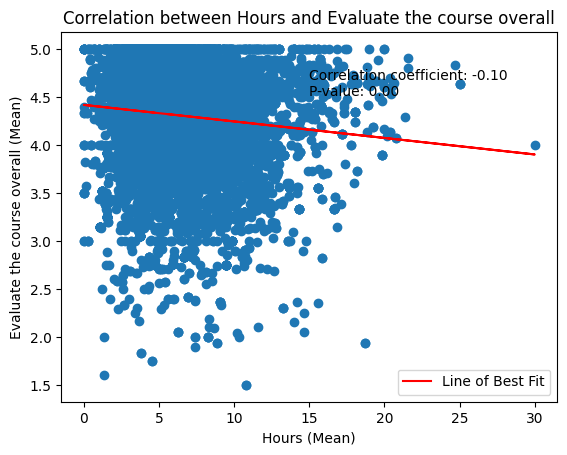

In [67]:
import json
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Load the JSON data
with open('2020-2024_Course_Data.json', 'r') as file:
    data = json.load(file)

# Initialize lists to store hours and overall evaluation ratings
hours = []
course_scores = []

# Iterate through each entry in the data
for entry in data:
    # Check if the entry has a 'Feedback' dictionary with 'Hours' and 'General' keys
    if 'Feedback' in entry and 'Hours' in entry['Feedback'] and 'General' in entry['Feedback']:
        # Extract hours and overall evaluation rating
        hours_data = entry['Feedback']['Hours']
        overall_data = entry['Feedback']['General'][0]

        # Check if hours_data has at least three elements and the third element is a dictionary with a 'Value' key
        if len(hours_data) > 2 and isinstance(hours_data[2], dict) and 'Value' in hours_data[2]:
            # Convert hours value to float and append to the list
            hours.append(float(hours_data[2]['Value']))
        else:
            # Handle missing or invalid hours data
            hours.append(np.nan)

        # Convert overall evaluation rating to float and append to the list
        course_scores.append(float(overall_data['Course Mean']))
    else:
        # Handle missing 'Feedback', 'Hours', or 'General' keys
        hours.append(np.nan)
        course_scores.append(np.nan)

# Convert lists to numpy arrays for correlation calculation
hours_array = np.array(hours)
course_scores_array = np.array(course_scores)

# Remove NaN values from the arrays
valid_indices = ~np.isnan(hours_array) & ~np.isnan(course_scores_array)
hours_array = hours_array[valid_indices]
course_scores_array = course_scores_array[valid_indices]

# Calculate the correlation coefficient and p-value
correlation_coefficient, p_value = pearsonr(hours_array, course_scores_array)

# Fit a linear regression line
slope, intercept = np.polyfit(hours_array, course_scores_array, 1)
line_of_best_fit = slope * hours_array + intercept

# Plot the data
plt.scatter(hours_array, course_scores_array)
plt.plot(hours_array, line_of_best_fit, color='red', label='Line of Best Fit')
plt.xlabel('Hours (Mean)')
plt.ylabel('Evaluate the course overall (Mean)')
plt.title('Correlation between Hours and Evaluate the course overall')
plt.text(0.5, 0.9, f'Correlation coefficient: {correlation_coefficient:.2f}\nP-value: {p_value:.2f}', transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
plt.legend()
plt.show()

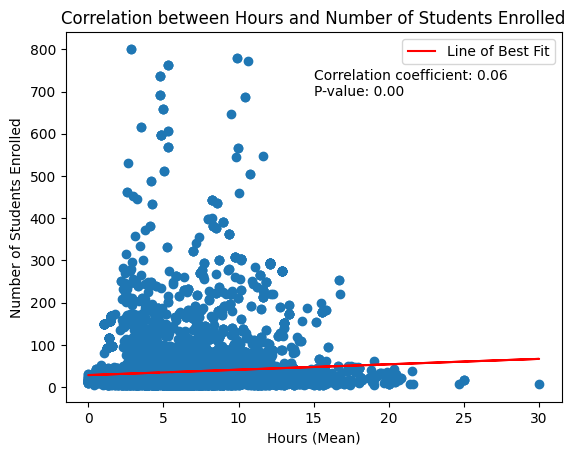

In [68]:
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Load the JSON data
with open('2020-2024_Course_Data.json', 'r') as file:
    data = json.load(file)

# Initialize lists to store hours and overall evaluation ratings
hours = []
course_scores = []

# Iterate through each entry in the data
for entry in data:
    # Check if the entry has a 'Feedback' dictionary with 'Hours' and 'Responses' keys
    if 'Feedback' in entry and 'Hours' in entry['Feedback'] and 'Responses' in entry['Feedback']:
        # Extract hours and overall evaluation rating
        hours_data = entry['Feedback']['Hours']
        responses = entry['Feedback']['Responses']

        # Check if 'Responses' list has at least two elements
        if len(responses) > 1:
            # Check if hours_data has at least three elements and the third element is a dictionary with a 'Value' key
            if len(hours_data) > 2 and isinstance(hours_data[2], dict) and 'Value' in hours_data[2]:
                # Convert hours value to float and append to the list
                hours.append(float(hours_data[2]['Value']))

                # Convert overall evaluation rating to float and append to the list
                course_scores.append(float(responses[1]['Students']))
            else:
                # Handle missing or invalid hours data
                hours.append(np.nan)
                course_scores.append(np.nan)
        else:
            # Handle missing or invalid 'Responses' data
            hours.append(np.nan)
            course_scores.append(np.nan)
    else:
        # Handle missing 'Feedback', 'Hours', or 'Responses' keys
        hours.append(np.nan)
        course_scores.append(np.nan)

# Convert lists to numpy arrays for correlation calculation
hours_array = np.array(hours)
course_scores_array = np.array(course_scores)

# Remove NaN values from the arrays
valid_indices = ~np.isnan(hours_array) & ~np.isnan(course_scores_array)
hours_array = hours_array[valid_indices]
course_scores_array = course_scores_array[valid_indices]

# Calculate the correlation coefficient and p-value
correlation_coefficient, p_value = pearsonr(hours_array, course_scores_array)

# Fit a linear regression line
slope, intercept = np.polyfit(hours_array, course_scores_array, 1)
line_of_best_fit = slope * hours_array + intercept

# Plot the data
plt.scatter(hours_array, course_scores_array)
plt.plot(hours_array, line_of_best_fit, color='red', label='Line of Best Fit')
plt.xlabel('Hours (Mean)')
plt.ylabel('Number of Students Enrolled')
plt.title('Correlation between Hours and Number of Students Enrolled')
plt.text(0.5, 0.9, f'Correlation coefficient: {correlation_coefficient:.2f}\nP-value: {p_value:.2f}', transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
plt.legend()
plt.show()

In [2]:
import json

# Load the existing JSON data
with open('2020-2024_Course_Data.json', 'r') as file:
    data = json.load(file)

# Initialize a list to hold the filtered data
filtered_data = []

# Iterate through each entry in the data
for entry in data:
    # Check if the entry's department is "General Education"
    if entry.get('Department') == 'General Education':
        # Add the entry to the filtered data list
        filtered_data.append(entry)

# Write the filtered data to a new JSON file
with open('2020-2024_geneds_only_course_data.json', 'w') as file:
    json.dump(filtered_data, file, indent=4)

print(f"Filtered data has been written to '2024_geneds_only_course_data.json'.")


Filtered data has been written to '2024_geneds_only_course_data.json'.


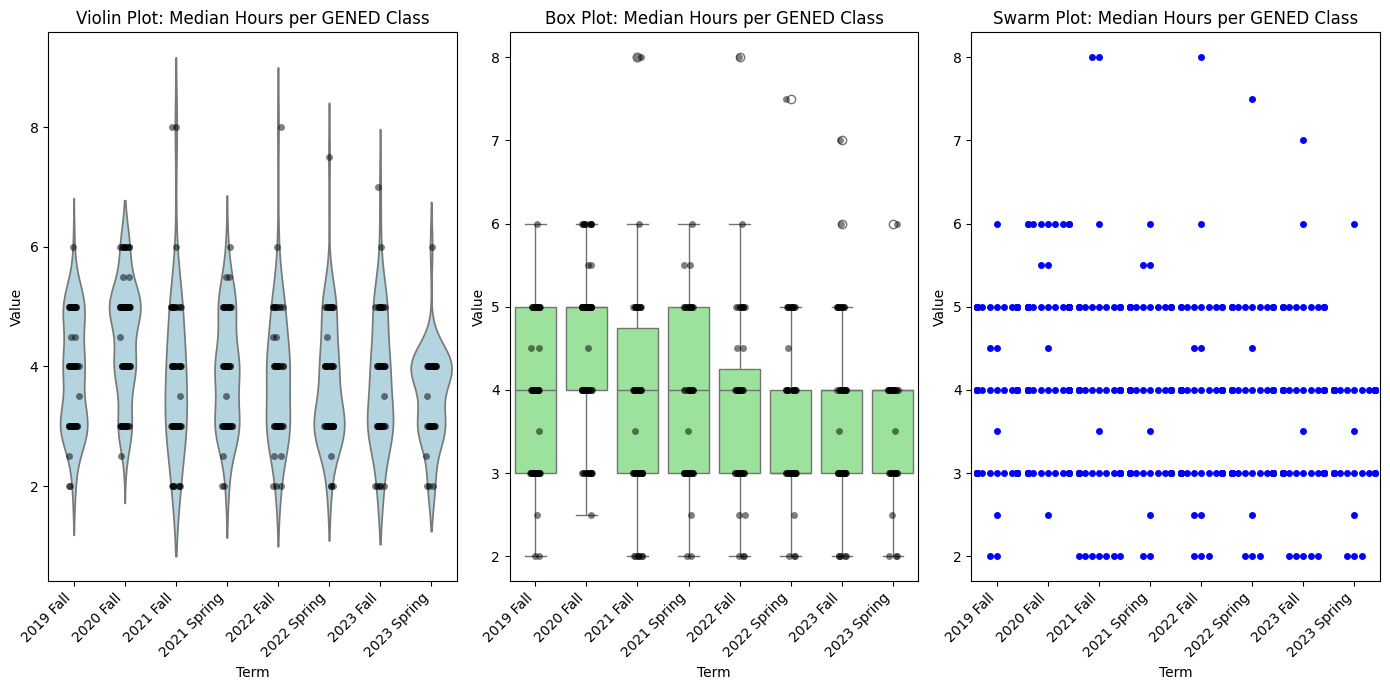

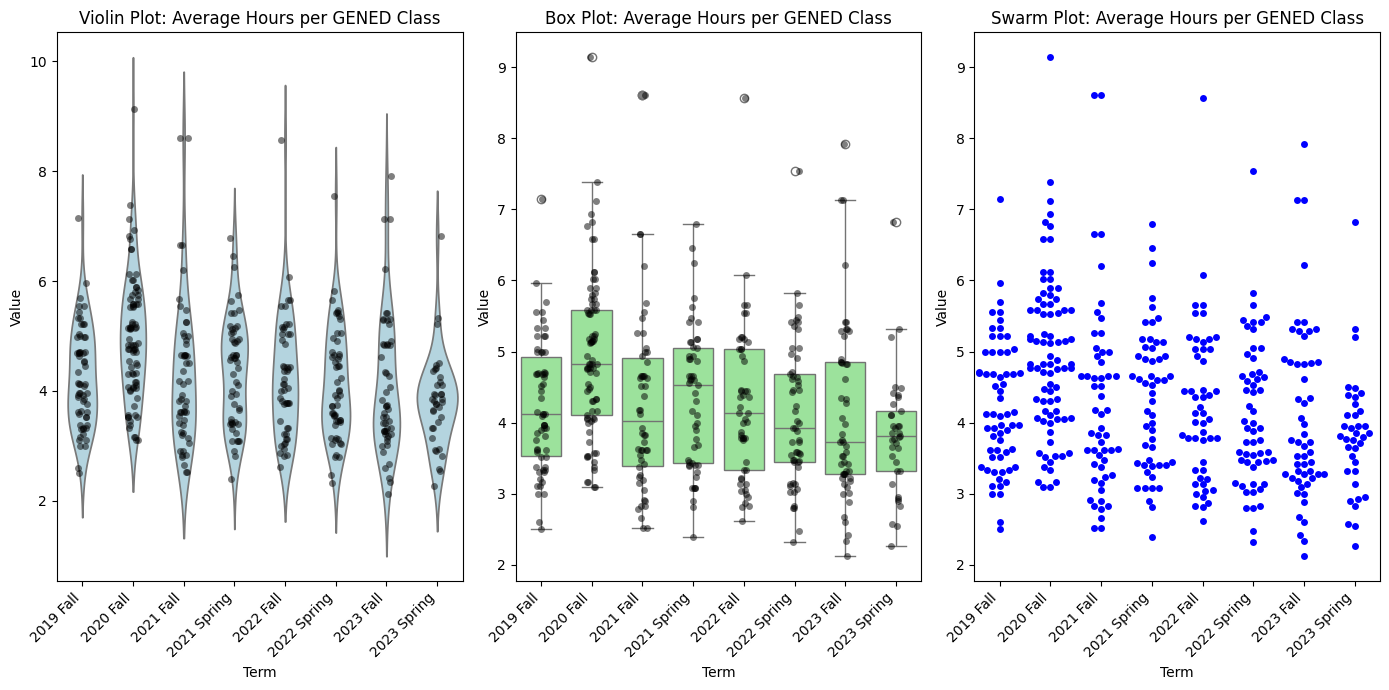

In [24]:
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def extract_hours_data(json_data):
    median_hours_data = []
    average_hours_data = []

    for course in json_data:
        term = course.get("Term", "")
        hours_data = course.get("Feedback", {}).get("Hours", [])

        # Extract the median value from the hours data
        median_hours = next((item['Value'] for item in hours_data if item['Statistics'] == "Median"), None)
        if median_hours:
            median_hours_data.append({'Term': term, 'Value': float(median_hours)})

        # Extract the mean value from the hours data
        average_hours = next((item['Value'] for item in hours_data if item['Statistics'] == "Mean"), None)
        if average_hours:
            average_hours_data.append({'Term': term, 'Value': float(average_hours)})

    return median_hours_data, average_hours_data

def plot_violin_and_box_plots(data, title):
    df = pd.DataFrame(data)
    df['Term'] = pd.Categorical(df['Term'], categories=sorted(df['Term'].unique()), ordered=True)
    df = df.sort_values('Term')

    plt.figure(figsize=(14, 7))

    plt.subplot(1, 3, 1)
    sns.violinplot(x='Term', y='Value', data=df, inner=None, color='lightblue')
    sns.stripplot(x='Term', y='Value', data=df, color='black', alpha=0.5, jitter=True)
    plt.title(f'Violin Plot: {title}')
    plt.xticks(rotation=45, ha='right')

    plt.subplot(1, 3, 2)
    sns.boxplot(x='Term', y='Value', data=df, color='lightgreen')
    sns.stripplot(x='Term', y='Value', data=df, color='black', alpha=0.5, jitter=True)
    plt.title(f'Box Plot: {title}')
    plt.xticks(rotation=45, ha='right')

    plt.subplot(1, 3, 3)
    sns.swarmplot(x='Term', y='Value', data=df, color='blue')
    plt.title(f'Swarm Plot: {title}')
    plt.xticks(rotation=45, ha='right')

    plt.tight_layout()
    plt.show()

# Load the JSON file
with open('2020-2024_geneds_only_course_data.json', 'r') as file:
    json_data = json.load(file)

# Extract data
median_hours_data, average_hours_data = extract_hours_data(json_data)

# Plot the graphics
plot_violin_and_box_plots(median_hours_data, 'Median Hours per GENED Class')
plot_violin_and_box_plots(average_hours_data, 'Average Hours per GENED Class')


Statistics Summary for Median Hours:
             Number of Courses      Mean  Median  Mode  Range  \
2019 Fall                 62.0  3.870968     4.0   3.0    4.0   
2020 Fall                 81.0  4.469136     5.0   5.0    3.5   
2021 Fall                 54.0  3.805556     4.0   3.0    6.0   
2021 Spring               53.0  3.886792     4.0   3.0    4.0   
2022 Fall                 51.0  3.803922     4.0   3.0    6.0   
2022 Spring               56.0  3.687500     3.0   3.0    5.5   
2023 Fall                 53.0  3.726415     4.0   3.0    5.0   
2023 Spring               37.0  3.513514     4.0   4.0    4.0   

             Standard Deviation  
2019 Fall              0.931839  
2020 Fall              0.943218  
2021 Fall              1.304624  
2021 Spring            0.953947  
2022 Fall              1.104891  
2022 Spring            1.020528  
2023 Fall              1.076703  
2023 Spring            0.777161  

Trend Analysis for Median Hours:
Trend (Slope of Regression Line): -0.

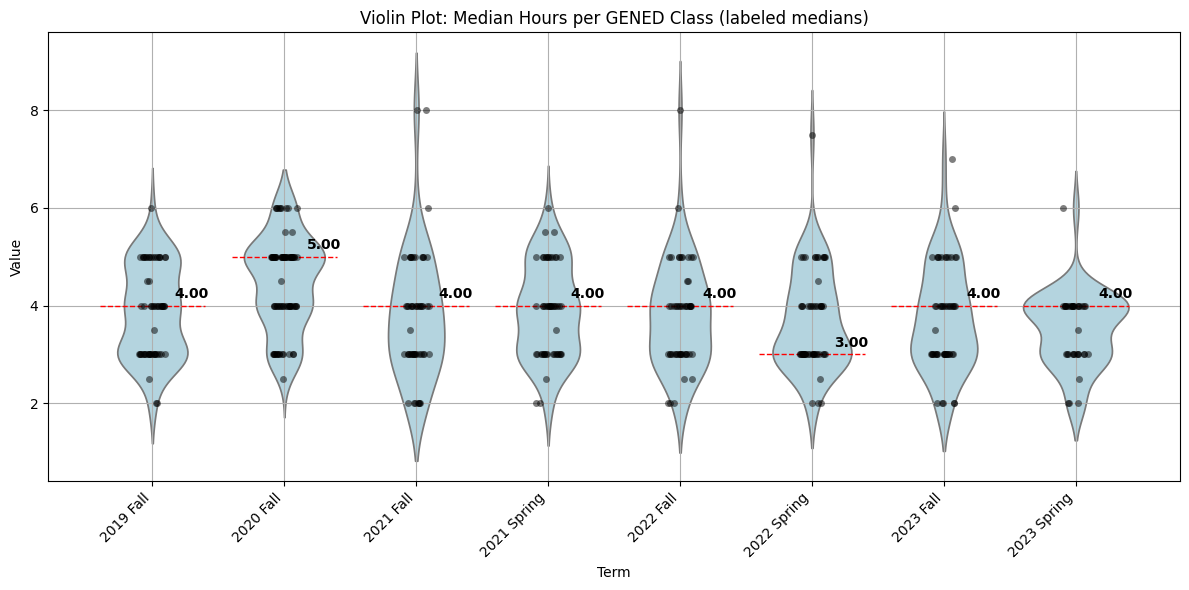

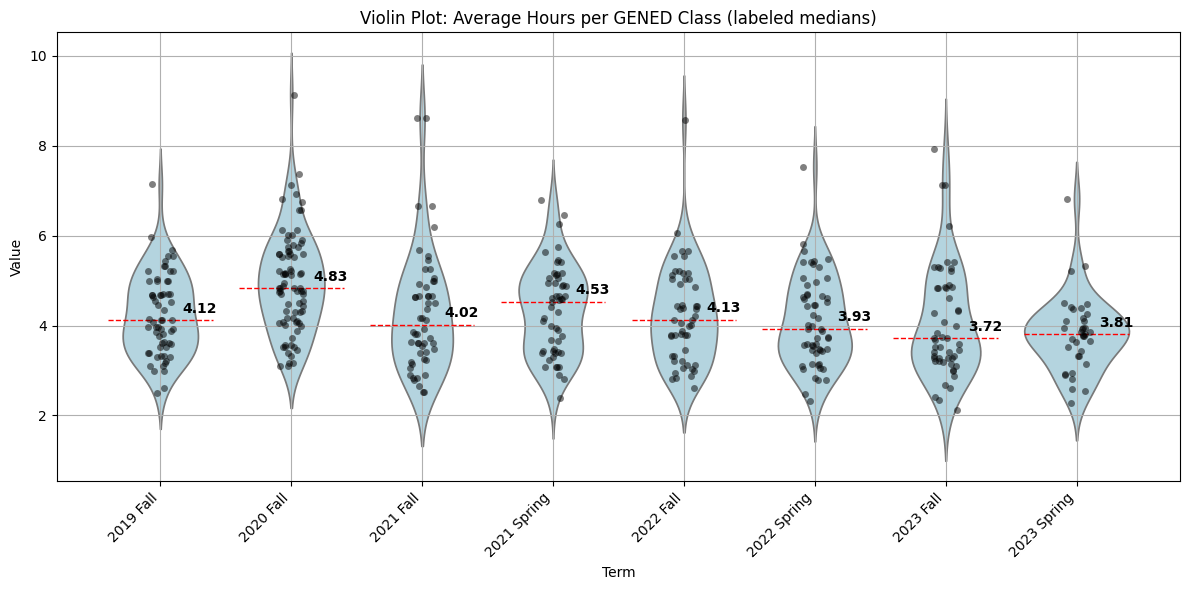

In [82]:
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from sklearn.linear_model import LinearRegression

def extract_hours_data(json_data):
    median_hours_data = []
    average_hours_data = []

    for course in json_data:
        term = course.get("Term", "")
        hours_data = course.get("Feedback", {}).get("Hours", [])

        # Extract the median value from the hours data
        median_hours = next((item['Value'] for item in hours_data if item['Statistics'] == "Median"), None)
        if median_hours:
            median_hours_data.append({'Term': term, 'Value': float(median_hours)})

        # Extract the mean value from the hours data
        average_hours = next((item['Value'] for item in hours_data if item['Statistics'] == "Mean"), None)
        if average_hours:
            average_hours_data.append({'Term': term, 'Value': float(average_hours)})

    return median_hours_data, average_hours_data

def compute_statistics(df):
    stats_summary = {}
    
    for term, group in df.groupby('Term'):
        values = group['Value']
        
        stats_summary[term] = {
            'Number of Courses': len(values),
            'Mean': values.mean(),
            'Median': values.median(),
            'Mode': values.mode().values[0] if not values.mode().empty else None,
            'Range': values.max() - values.min(),
            'Standard Deviation': values.std()
        }
    
    return pd.DataFrame(stats_summary).T

def plot_violin_plot(data, title):
    df = pd.DataFrame(data)
    df['Term'] = pd.Categorical(df['Term'], categories=sorted(df['Term'].unique()), ordered=True)
    df = df.sort_values('Term')

    plt.figure(figsize=(12, 6))
    ax = sns.violinplot(x='Term', y='Value', data=df, inner=None, color='lightblue')
    sns.stripplot(x='Term', y='Value', data=df, color='black', alpha=0.5, jitter=True)
    
    # Calculate and plot median lines
    medians = df.groupby('Term')['Value'].median().sort_index()
    
    # Add a red line and offset labels for each violin plot
    for i, term in enumerate(sorted(df['Term'].unique())):
        median_value = medians[term]
        x_pos = i
        y_min, y_max = ax.get_ylim()
        
        if y_min <= median_value <= y_max:
            plt.plot([x_pos - 0.4, x_pos + 0.4], [median_value, median_value], color='red', linestyle='--', linewidth=1)
            # Add label for median value with vertical and horizontal offset
            y_offset = 0.1 # Offset by 3% of the y-axis range
            x_offset = 0.3  # Alternate x-offsets for clarity
            plt.text(x_pos + x_offset, median_value + y_offset, f'{median_value:.2f}', color='black', fontsize=10, fontweight='bold', ha='center', va='bottom')
    
    plt.title(f'Violin Plot: {title}')
    plt.xticks(rotation=45, ha='right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def analyze_trend(df):
    # Prepare the data for linear regression
    df = df.sort_values('Term')
    terms = df['Term'].astype('category').cat.codes.values.reshape(-1, 1)  # Convert terms to numeric codes
    values = df['Value'].values
    
    # Perform linear regression
    model = LinearRegression()
    model.fit(terms, values)
    
    trend = model.coef_[0]
    intercept = model.intercept_
    r_value = model.score(terms, values)
    
    # Calculate p-value for the trend
    _, p_value = stats.pearsonr(terms.flatten(), values)
    
    return trend, r_value, p_value

# Load the JSON file
with open('2020-2024_geneds_only_course_data.json', 'r') as file:
    json_data = json.load(file)

# Extract data
median_hours_data, average_hours_data = extract_hours_data(json_data)

# Compute statistics
df_median_hours = pd.DataFrame(median_hours_data)
df_average_hours = pd.DataFrame(average_hours_data)

stats_median_hours = compute_statistics(df_median_hours)
stats_average_hours = compute_statistics(df_average_hours)

# Analyze trends
trend_median_hours, r_value_median_hours, p_value_median_hours = analyze_trend(df_median_hours)
trend_average_hours, r_value_average_hours, p_value_average_hours = analyze_trend(df_average_hours)

# Print statistics and trend analysis
print("Statistics Summary for Median Hours:")
print(stats_median_hours)
print("\nTrend Analysis for Median Hours:")
print(f"Trend (Slope of Regression Line): {trend_median_hours:.2f}")
print(f"R-squared: {r_value_median_hours:.2f}")
print(f"P-value: {p_value_median_hours:.4f}")
print(f"Statistically Significant Trend: {'Yes' if p_value_median_hours < 0.05 else 'No'}")

print("\nStatistics Summary for Average Hours:")
print(stats_average_hours)
print("\nTrend Analysis for Average Hours:")
print(f"Trend (Slope of Regression Line): {trend_average_hours:.2f}")
print(f"R-squared: {r_value_average_hours:.2f}")
print(f"P-value: {p_value_average_hours:.4f}")
print(f"Statistically Significant Trend: {'Yes' if p_value_average_hours < 0.05 else 'No'}")

# Plot the graphics
plot_violin_plot(median_hours_data, 'Median Hours per GENED Class (labeled medians)')
plot_violin_plot(average_hours_data, 'Average Hours per GENED Class (labeled medians)')


Mean Squared Error: 1.22
R-squared: 0.04
Regression Coefficient for Time (Semester): -0.10
Intercept: 4.63


ValueError: The number of FixedLocator locations (447), usually from a call to set_ticks, does not match the number of labels (8).

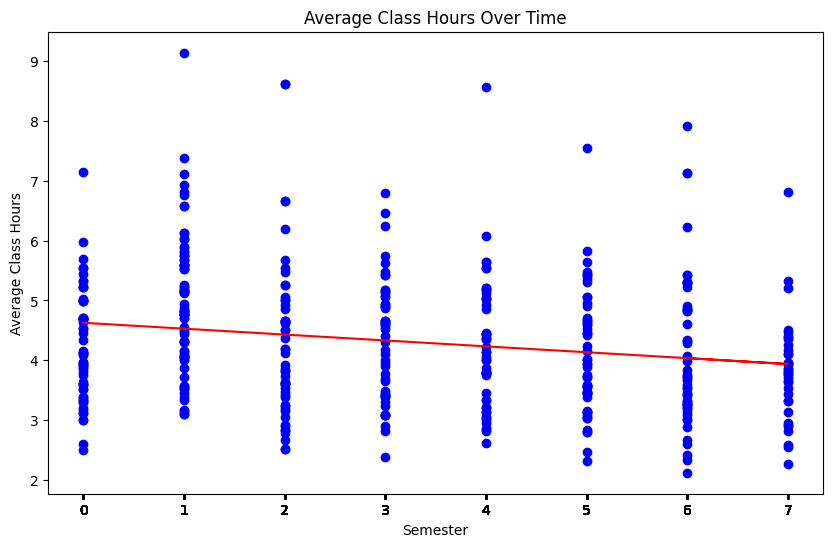

In [35]:
import json
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

def extract_hours_data(json_data):
    hours_data = []

    for course in json_data:
        term = course.get("Term", "")
        hours = course.get("Feedback", {}).get("Hours", [])

        # Extract the mean value from the hours data
        average_hours = next((item['Value'] for item in hours if item['Statistics'] == "Mean"), None)
        if average_hours:
            hours_data.append({'Term': term, 'Value': float(average_hours)})

    return hours_data

def encode_terms(df):
    # Convert terms to a numeric format
    df['Term'] = pd.Categorical(df['Term'])
    df['Term_num'] = df['Term'].cat.codes
    return df

def perform_regression_analysis(df):
    X = df[['Term_num']]
    y = df['Value']

    model = LinearRegression()
    model.fit(X, y)
    
    # Predict and calculate metrics
    y_pred = model.predict(X)
    mse = mean_squared_error(y, y_pred)
    r2 = model.score(X, y)

    return model, mse, r2

# Load the JSON file
with open('2020-2024_geneds_only_course_data.json', 'r') as file:
    json_data = json.load(file)

# Extract data
hours_data = extract_hours_data(json_data)

# Convert to DataFrame
df = pd.DataFrame(hours_data)
df = encode_terms(df)

# Perform regression analysis
model, mse, r2 = perform_regression_analysis(df)

# Print summary statistics
print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared: {r2:.2f}")
print(f"Regression Coefficient for Time (Semester): {model.coef_[0]:.2f}")
print(f"Intercept: {model.intercept_:.2f}")

# Plot results
plt.figure(figsize=(10, 6))
plt.scatter(df['Term_num'], df['Value'], color='blue', label='Data Points')
plt.plot(df['Term_num'], model.predict(df[['Term_num']]), color='red', label='Regression Line')
plt.xlabel('Semester')
plt.ylabel('Average Class Hours')
plt.title('Average Class Hours Over Time')
plt.xticks(ticks=df['Term_num'], labels=df['Term'].unique(), rotation=45, ha='right')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Statistics Summary:
             Number of Courses      Mean  Median  Mode  Range  \
2019 Fall                 62.0  4.198548   4.255  4.27   1.05   
2020 Fall                 81.0  4.171235   4.220  4.23   1.78   
2021 Fall                 54.0  4.052593   4.115  3.89   1.79   
2021 Spring               53.0  4.140377   4.130  3.33   1.87   
2022 Fall                 51.0  4.044118   4.060  4.19   1.75   
2022 Spring               56.0  4.072321   4.100  3.88   2.15   
2023 Fall                 53.0  4.070000   4.120  3.85   1.66   
2023 Spring               37.0  3.998919   3.970  3.62   1.68   

             Standard Deviation  
2019 Fall              0.261646  
2020 Fall              0.318741  
2021 Fall              0.364837  
2021 Spring            0.466703  
2022 Fall              0.341340  
2022 Spring            0.381795  
2023 Fall              0.416131  
2023 Spring            0.414453  

Trend Analysis:
Trend (Slope of Regression Line): -0.02
R-squared: 0.02
P-value: 0.0025

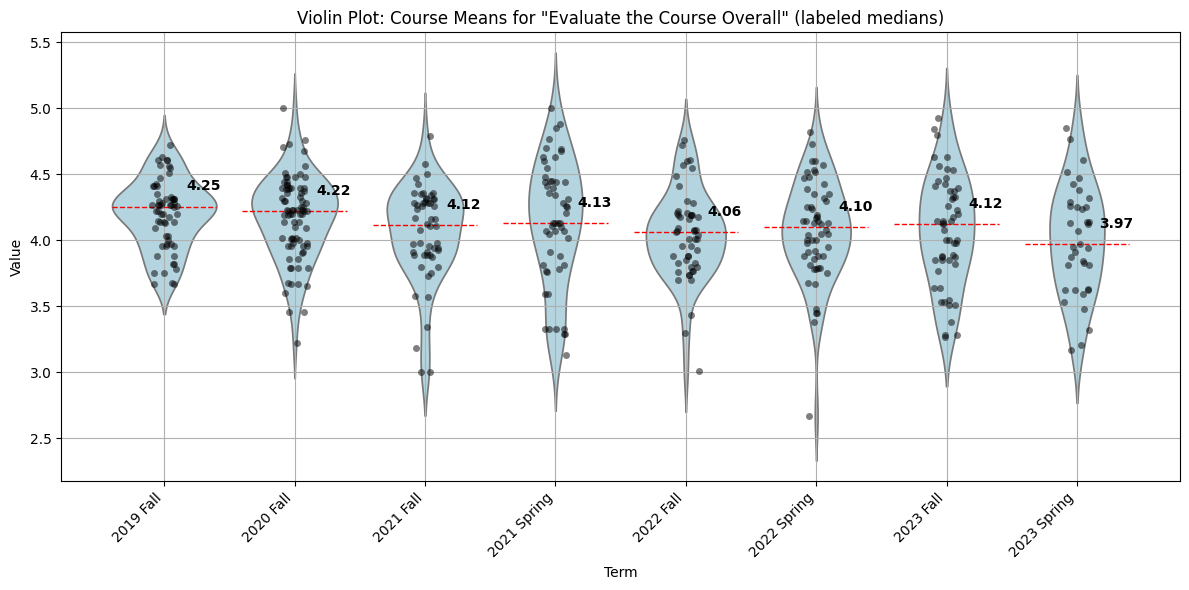

In [81]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.linear_model import LinearRegression

def extract_course_mean_data(json_data):
    course_mean_data = []

    for course in json_data:
        term = course.get("Term", "")
        general_feedback = course.get("Feedback", {}).get("General", [])

        # Extract the Course Mean value from the general feedback data
        course_mean = next((item['Course Mean'] for item in general_feedback if item.get('') == "Evaluate the course overall."), None)
        if course_mean:
            course_mean_data.append({'Term': term, 'Value': float(course_mean)})

    return course_mean_data

def compute_statistics(df):
    stats_summary = {}
    
    for term, group in df.groupby('Term'):
        values = group['Value']
        
        stats_summary[term] = {
            'Number of Courses': len(values),
            'Mean': values.mean(),
            'Median': values.median(),
            'Mode': values.mode().values[0] if not values.mode().empty else None,
            'Range': values.max() - values.min(),
            'Standard Deviation': values.std()
        }
    
    return pd.DataFrame(stats_summary).T

def plot_violin_plot(data, title):
    df = pd.DataFrame(data)
    df['Term'] = pd.Categorical(df['Term'], categories=sorted(df['Term'].unique()), ordered=True)
    df = df.sort_values('Term')

    plt.figure(figsize=(12, 6))
    ax = sns.violinplot(x='Term', y='Value', data=df, inner=None, color='lightblue')
    sns.stripplot(x='Term', y='Value', data=df, color='black', alpha=0.5, jitter=True)
    
    # Calculate and plot median lines
    medians = df.groupby('Term')['Value'].median().sort_index()
    
    # Get the maximum y-value of the plot
    y_max = ax.get_ylim()[1]
    
    # Add a red line and position labels above each violin plot
    for i, term in enumerate(sorted(df['Term'].unique())):
        median_value = medians[term]
        x_pos = i
        
        if median_value <= y_max:
            plt.plot([x_pos - 0.4, x_pos + 0.4], [median_value, median_value], color='red', linestyle='--', linewidth=1)
            # Add label for median value with vertical and horizontal offset
            y_offset = 0.1 # Offset by 3% of the y-axis range
            x_offset = 0.3  # Alternate x-offsets for clarity
            plt.text(x_pos + x_offset, median_value + y_offset, f'{median_value:.2f}', color='black', fontsize=10, fontweight='bold', ha='center', va='bottom')
    
    plt.title(f'Violin Plot: {title}')
    plt.xticks(rotation=45, ha='right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def analyze_trend(df):
    # Prepare the data for linear regression
    df = df.sort_values('Term')
    terms = df['Term'].astype('category').cat.codes.values.reshape(-1, 1)  # Convert terms to numeric codes
    values = df['Value'].values
    
    # Perform linear regression
    model = LinearRegression()
    model.fit(terms, values)
    
    trend = model.coef_[0]
    intercept = model.intercept_
    r_value = model.score(terms, values)
    
    # Calculate p-value for the trend
    _, p_value = stats.pearsonr(terms.flatten(), values)
    
    return trend, r_value, p_value

# Load the JSON file
with open('2020-2024_geneds_only_course_data.json', 'r') as file:
    json_data = json.load(file)

# Extract data
course_mean_data = extract_course_mean_data(json_data)

# Compute statistics
df = pd.DataFrame(course_mean_data)
stats_summary = compute_statistics(df)
trend, r_value, p_value = analyze_trend(df)

# Print statistics and trend analysis
print("Statistics Summary:")
print(stats_summary)
print("\nTrend Analysis:")
print(f"Trend (Slope of Regression Line): {trend:.2f}")
print(f"R-squared: {r_value:.2f}")
print(f"P-value: {p_value:.4f}")
print(f"Statistically Significant Trend: {'Yes' if p_value < 0.05 else 'No'}")

# Plot the graphics
plot_violin_plot(course_mean_data, 'Course Means for "Evaluate the Course Overall" (labeled medians)')


Statistics Summary:
             Number of Courses      Mean  Median  Mode  Range  \
2019 Fall                 62.0  4.506452   4.515  4.50   1.26   
2020 Fall                 81.0  4.570741   4.630  4.63   1.33   
2021 Fall                 54.0  4.440370   4.495  4.47   1.35   
2021 Spring               53.0  4.510189   4.610  4.50   2.33   
2022 Fall                 51.0  4.396275   4.400  4.53   1.32   
2022 Spring               56.0  4.440000   4.470  4.40   2.26   
2023 Fall                 53.0  4.429057   4.430  4.73   1.43   
2023 Spring               37.0  4.408378   4.420  4.09   1.09   

             Standard Deviation  
2019 Fall              0.287488  
2020 Fall              0.292915  
2021 Fall              0.294900  
2021 Spring            0.462849  
2022 Fall              0.299786  
2022 Spring            0.379981  
2023 Fall              0.361244  
2023 Spring            0.305882  

Trend Analysis:
Trend (Slope of Regression Line): -0.02
R-squared: 0.02
P-value: 0.0061

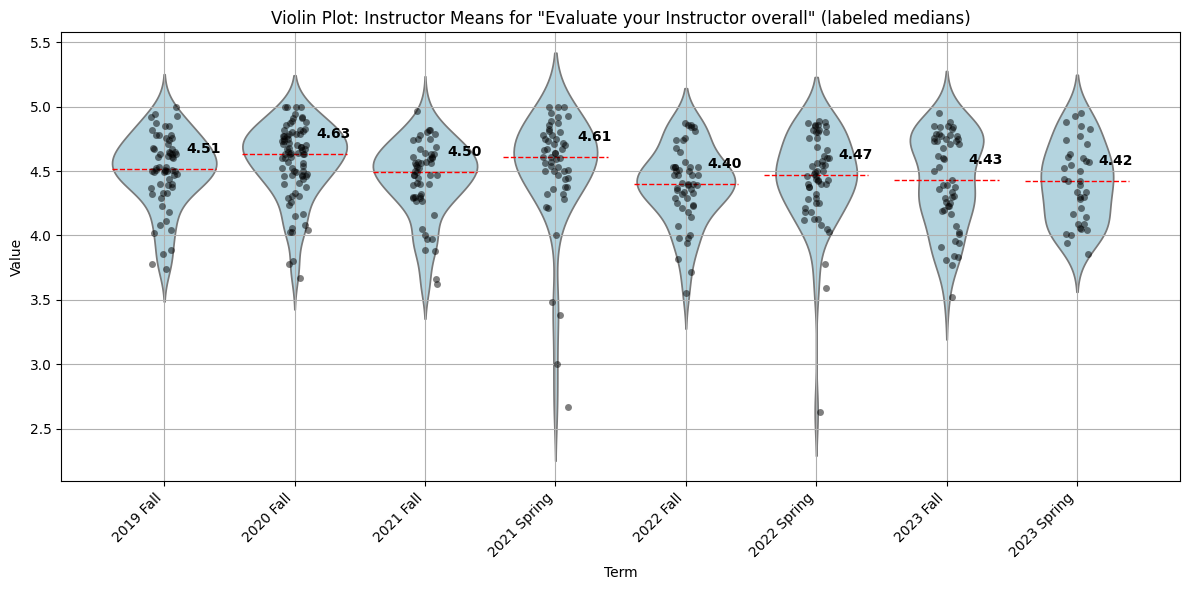

In [80]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.linear_model import LinearRegression

def extract_instructor_mean_data(json_data):
    instructor_mean_data = []

    for course in json_data:
        term = course.get("Term", "")
        instructor_feedback = course.get("Feedback", {}).get("Instructor", [])

        # Extract the Instructor Mean value from the instructor feedback data
        instructor_mean = next((item['Instructor Mean'] for item in instructor_feedback if item.get('') == "Evaluate your Instructor overall."), None)
        if instructor_mean:
            instructor_mean_data.append({'Term': term, 'Value': float(instructor_mean)})

    return instructor_mean_data

def compute_statistics(df):
    stats_summary = {}
    
    for term, group in df.groupby('Term'):
        values = group['Value']
        
        stats_summary[term] = {
            'Number of Courses': len(values),
            'Mean': values.mean(),
            'Median': values.median(),
            'Mode': values.mode().values[0] if not values.mode().empty else None,
            'Range': values.max() - values.min(),
            'Standard Deviation': values.std()
        }
    
    return pd.DataFrame(stats_summary).T

def plot_violin_plot(data, title):
    df = pd.DataFrame(data)
    df['Term'] = pd.Categorical(df['Term'], categories=sorted(df['Term'].unique()), ordered=True)
    df = df.sort_values('Term')

    plt.figure(figsize=(12, 6))
    ax = sns.violinplot(x='Term', y='Value', data=df, inner=None, color='lightblue')
    sns.stripplot(x='Term', y='Value', data=df, color='black', alpha=0.5, jitter=True)
    
    # Calculate and plot median lines
    medians = df.groupby('Term')['Value'].median().sort_index()
    
    # Add a red line for each violin plot
    for i, term in enumerate(sorted(df['Term'].unique())):
        median_value = medians[term]
        x_pos = i
        y_min, y_max = ax.get_ylim()
        
        if y_min <= median_value <= y_max:
            plt.plot([x_pos - 0.4, x_pos + 0.4], [median_value, median_value], color='red', linestyle='--', linewidth=1)
            # Add label for median value with vertical and horizontal offset
            y_offset = 0.1 # Offset by 3% of the y-axis range
            x_offset = 0.3  # Alternate x-offsets for clarity
            plt.text(x_pos + x_offset, median_value + y_offset, f'{median_value:.2f}', color='black', fontsize=10, fontweight='bold', ha='center', va='bottom')
    
    plt.title(f'Violin Plot: {title}')
    plt.xticks(rotation=45, ha='right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def analyze_trend(df):
    # Prepare the data for linear regression
    df = df.sort_values('Term')
    terms = df['Term'].astype('category').cat.codes.values.reshape(-1, 1)  # Convert terms to numeric codes
    values = df['Value'].values
    
    # Perform linear regression
    model = LinearRegression()
    model.fit(terms, values)
    
    trend = model.coef_[0]
    intercept = model.intercept_
    r_value = model.score(terms, values)
    
    # Calculate p-value for the trend
    _, p_value = stats.pearsonr(terms.flatten(), values)
    
    return trend, r_value, p_value

# Load the JSON file
with open('2020-2024_geneds_only_course_data.json', 'r') as file:
    json_data = json.load(file)

# Extract data
instructor_mean_data = extract_instructor_mean_data(json_data)

# Compute statistics
df = pd.DataFrame(instructor_mean_data)
stats_summary = compute_statistics(df)
trend, r_value, p_value = analyze_trend(df)

# Print statistics and trend analysis
print("Statistics Summary:")
print(stats_summary)
print("\nTrend Analysis:")
print(f"Trend (Slope of Regression Line): {trend:.2f}")
print(f"R-squared: {r_value:.2f}")
print(f"P-value: {p_value:.4f}")
print(f"Statistically Significant Trend: {'Yes' if p_value < 0.05 else 'No'}")

# Plot the graphics
plot_violin_plot(instructor_mean_data, 'Instructor Means for "Evaluate your Instructor overall" (labeled medians)')


Statistics Summary:
             Number of Courses      Mean  Median  Mode  Range  \
2019 Fall                 62.0  3.959355   3.925  3.96   1.46   
2020 Fall                 81.0  4.036296   4.060  3.95   1.89   
2021 Fall                 54.0  3.906296   3.940  4.13   2.04   
2021 Spring               53.0  4.019623   4.020  3.40   1.71   
2022 Fall                 51.0  3.894510   3.910  3.91   1.89   
2022 Spring               56.0  3.955357   3.940  3.94   2.02   
2023 Fall                 53.0  3.930189   4.000  4.00   2.19   
2023 Spring               37.0  3.925405   3.900  3.34   1.66   

             Standard Deviation  
2019 Fall              0.309324  
2020 Fall              0.390495  
2021 Fall              0.400063  
2021 Spring            0.476344  
2022 Fall              0.373365  
2022 Spring            0.379875  
2023 Fall              0.525849  
2023 Spring            0.398501  

Trend Analysis:
Trend (Slope of Regression Line): -0.01
R-squared: 0.00
P-value: 0.2367

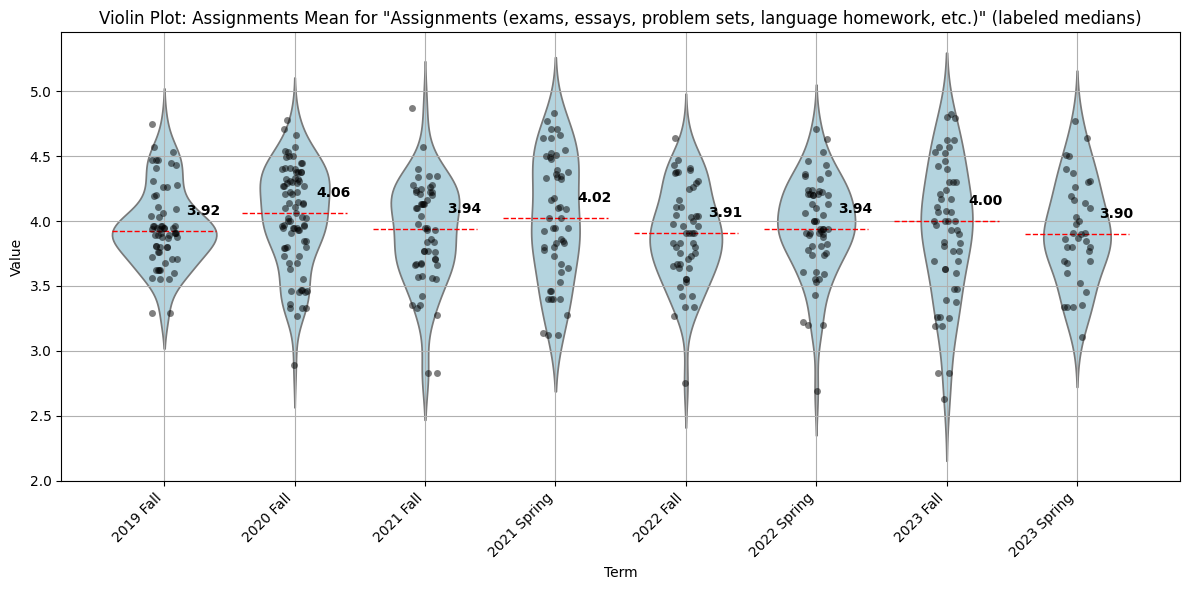

In [79]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.linear_model import LinearRegression

def extract_assignments_data(json_data):
    assignments_data = []

    for course in json_data:
        term = course.get("Term", "")
        assignments_feedback = course.get("Feedback", {}).get("General", [])

        # Extract the Assignment Mean value from the assignments feedback data
        assignments_mean = next((item['Course Mean'] for item in assignments_feedback if item.get('') == "Assignments (exams, essays, problem sets, language homework, etc.)"), None)
        if assignments_mean:
            assignments_data.append({'Term': term, 'Value': float(assignments_mean)})

    return assignments_data

def compute_statistics(df):
    stats_summary = {}
    
    for term, group in df.groupby('Term'):
        values = group['Value']
        
        stats_summary[term] = {
            'Number of Courses': len(values),
            'Mean': values.mean(),
            'Median': values.median(),
            'Mode': values.mode().values[0] if not values.mode().empty else None,
            'Range': values.max() - values.min(),
            'Standard Deviation': values.std()
        }
    
    return pd.DataFrame(stats_summary).T

def plot_violin_plot(data, title):
    df = pd.DataFrame(data)
    df['Term'] = pd.Categorical(df['Term'], categories=sorted(df['Term'].unique()), ordered=True)
    df = df.sort_values('Term')

    plt.figure(figsize=(12, 6))
    ax = sns.violinplot(x='Term', y='Value', data=df, inner=None, color='lightblue')
    sns.stripplot(x='Term', y='Value', data=df, color='black', alpha=0.5, jitter=True)
    
    # Calculate and plot median lines
    medians = df.groupby('Term')['Value'].median().sort_index()
    
    # Add a red line for each violin plot
    for i, term in enumerate(sorted(df['Term'].unique())):
        median_value = medians[term]
        x_pos = i
        y_min, y_max = ax.get_ylim()
        
        if y_min <= median_value <= y_max:
            plt.plot([x_pos - 0.4, x_pos + 0.4], [median_value, median_value], color='red', linestyle='--', linewidth=1)
            # Add label for median value with vertical and horizontal offset
            y_offset = 0.1 # Offset by 3% of the y-axis range
            x_offset = 0.3  # Alternate x-offsets for clarity
            plt.text(x_pos + x_offset, median_value + y_offset, f'{median_value:.2f}', color='black', fontsize=10, fontweight='bold', ha='center', va='bottom')

    plt.title(f'Violin Plot: {title}')
    plt.xticks(rotation=45, ha='right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def analyze_trend(df):
    # Prepare the data for linear regression
    df = df.sort_values('Term')
    terms = df['Term'].astype('category').cat.codes.values.reshape(-1, 1)  # Convert terms to numeric codes
    values = df['Value'].values
    
    # Perform linear regression
    model = LinearRegression()
    model.fit(terms, values)
    
    trend = model.coef_[0]
    intercept = model.intercept_
    r_value = model.score(terms, values)
    
    # Calculate p-value for the trend
    _, p_value = stats.pearsonr(terms.flatten(), values)
    
    return trend, r_value, p_value

# Load the JSON file
with open('2020-2024_geneds_only_course_data.json', 'r') as file:
    json_data = json.load(file)

# Extract data
assignments_data = extract_assignments_data(json_data)

# Compute statistics
df = pd.DataFrame(assignments_data)
stats_summary = compute_statistics(df)
trend, r_value, p_value = analyze_trend(df)

# Print statistics and trend analysis
print("Statistics Summary:")
print(stats_summary)
print("\nTrend Analysis:")
print(f"Trend (Slope of Regression Line): {trend:.2f}")
print(f"R-squared: {r_value:.2f}")
print(f"P-value: {p_value:.4f}")
print(f"Statistically Significant Trend: {'Yes' if p_value < 0.05 else 'No'}")

# Plot the graphics
plot_violin_plot(assignments_data, 'Assignments Mean for "Assignments (exams, essays, problem sets, language homework, etc.)" (labeled medians)')


Statistics Summary:
             Number of Courses      Mean  Median  Mode  Range  \
2019 Fall                 62.0  4.301935   4.330  4.21   1.47   
2020 Fall                 81.0  4.302963   4.360  4.50   1.56   
2021 Fall                 54.0  4.267407   4.345  4.36   1.62   
2021 Spring               53.0  4.260189   4.360  3.40   1.46   
2022 Fall                 51.0  4.263333   4.200  4.13   1.16   
2022 Spring               56.0  4.268036   4.330  4.33   1.55   
2023 Fall                 53.0  4.257170   4.250  4.42   1.46   
2023 Spring               37.0  4.161622   4.170  3.68   1.65   

             Standard Deviation  
2019 Fall              0.317133  
2020 Fall              0.291730  
2021 Fall              0.310205  
2021 Spring            0.373237  
2022 Fall              0.242229  
2022 Spring            0.325730  
2023 Fall              0.332828  
2023 Spring            0.395710  

Trend Analysis:
Trend (Slope of Regression Line): -0.01
R-squared: 0.01
P-value: 0.0530

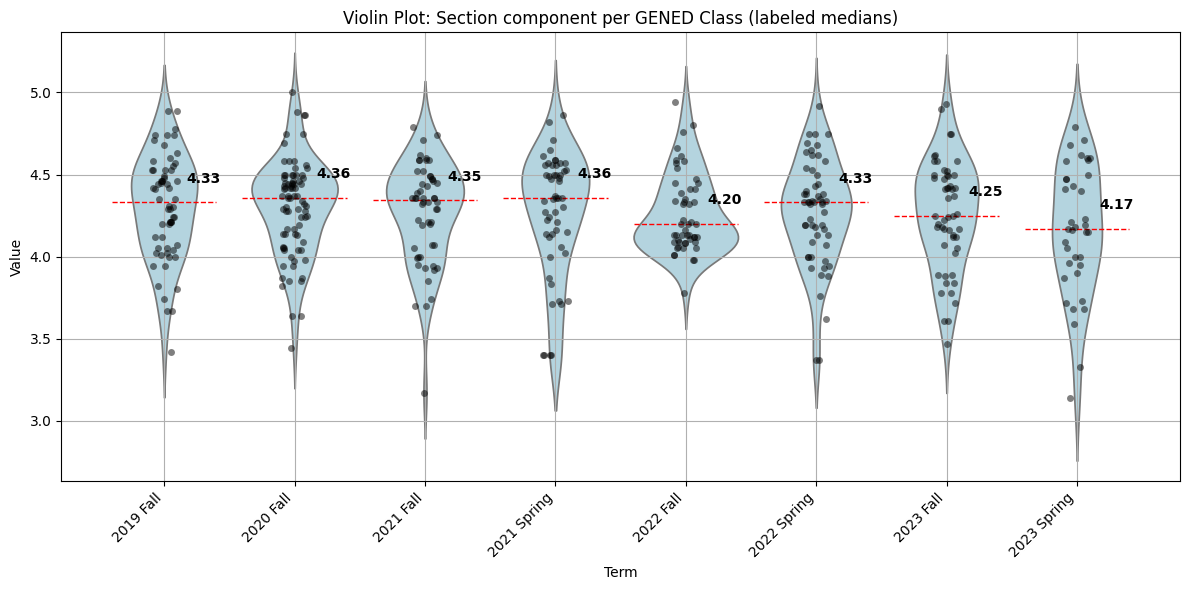

In [75]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.linear_model import LinearRegression

def extract_assignments_data(json_data):
    assignments_data = []

    for course in json_data:
        term = course.get("Term", "")
        assignments_feedback = course.get("Feedback", {}).get("General", [])

        # Extract the Assignment Mean value from the assignments feedback data
        assignments_mean = next((item['Course Mean'] for item in assignments_feedback if item.get('') == "Section component of the course"), None)
        if assignments_mean:
            assignments_data.append({'Term': term, 'Value': float(assignments_mean)})

    return assignments_data

def compute_statistics(df):
    stats_summary = {}
    
    for term, group in df.groupby('Term'):
        values = group['Value']
        
        stats_summary[term] = {
            'Number of Courses': len(values),
            'Mean': values.mean(),
            'Median': values.median(),
            'Mode': values.mode().values[0] if not values.mode().empty else None,
            'Range': values.max() - values.min(),
            'Standard Deviation': values.std()
        }
    
    return pd.DataFrame(stats_summary).T

def analyze_trend(df):
    # Prepare the data for linear regression
    df = df.sort_values('Term')
    terms = df['Term'].astype('category').cat.codes.values.reshape(-1, 1)  # Convert terms to numeric codes
    values = df['Value'].values
    
    # Perform linear regression
    model = LinearRegression()
    model.fit(terms, values)
    
    trend = model.coef_[0]
    intercept = model.intercept_
    r_value = model.score(terms, values)
    
    # Calculate p-value for the trend
    _, p_value = stats.pearsonr(terms.flatten(), values)
    
    return trend, r_value, p_value

def plot_violin_plot(data, title):
    df = pd.DataFrame(data)
    df['Term'] = pd.Categorical(df['Term'], categories=sorted(df['Term'].unique()), ordered=True)
    df = df.sort_values('Term')

    plt.figure(figsize=(12, 6))
    ax = sns.violinplot(x='Term', y='Value', data=df, inner=None, color='lightblue')
    sns.stripplot(x='Term', y='Value', data=df, color='black', alpha=0.5, jitter=True)
    
    # Calculate and plot median lines
    medians = df.groupby('Term')['Value'].median().sort_index()
    
    # Add a red line for each violin plot
    for i, term in enumerate(sorted(df['Term'].unique())):
        median_value = medians[term]
        x_pos = i
        y_min, y_max = ax.get_ylim()
        
        if y_min <= median_value <= y_max:
            plt.plot([x_pos - 0.4, x_pos + 0.4], [median_value, median_value], color='red', linestyle='--', linewidth=1)
            # Add label for median value with vertical and horizontal offset
            y_offset = 0.1 # Offset by 3% of the y-axis range
            x_offset = 0.3  # Alternate x-offsets for clarity
            plt.text(x_pos + x_offset, median_value + y_offset, f'{median_value:.2f}', color='black', fontsize=10, fontweight='bold', ha='center', va='bottom')
    
    plt.title(f'Violin Plot: {title}')
    plt.xticks(rotation=45, ha='right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Load the JSON file
with open('2020-2024_geneds_only_course_data.json', 'r') as file:
    json_data = json.load(file)

# Extract data
assignments_data = extract_assignments_data(json_data)

# Compute statistics
df = pd.DataFrame(assignments_data)
stats_summary = compute_statistics(df)
trend, r_value, p_value = analyze_trend(df)

print("Statistics Summary:")
print(stats_summary)
print("\nTrend Analysis:")
print(f"Trend (Slope of Regression Line): {trend:.2f}")
print(f"R-squared: {r_value:.2f}")
print(f"P-value: {p_value:.4f}")
print(f"Statistically Significant Trend: {'Yes' if p_value < 0.05 else 'No'}")

# Plot the graphics
plot_violin_plot(assignments_data, 'Section component per GENED Class (labeled medians)')


Statistics Summary:
            Value
count  447.000000
mean     4.100671
std      0.410638
min      2.370000
25%      3.850000
50%      4.140000
75%      4.380000
max      5.000000

Trend Analysis:
Trend (Slope of Regression Line): -0.02
R-squared: 0.02
P-value: 0.0046
Statistically Significant Trend: Yes


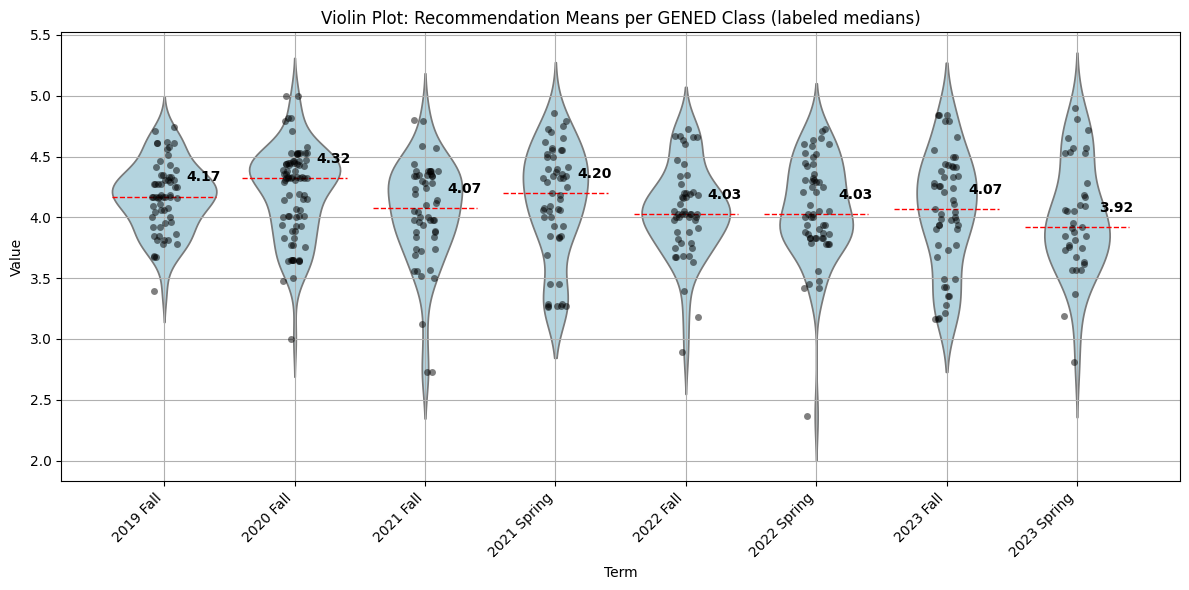

In [78]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.linear_model import LinearRegression

def extract_recommendation_mean_data(json_data):
    recommendation_mean_data = []

    for course in json_data:
        term = course.get("Term", "")
        recommendation_stats = course.get("Feedback", {}).get("Recommendation_stats", [])

        # Extract the Mean value from the recommendation stats
        mean_value = next((item['Value'] for item in recommendation_stats if item['Statistics'] == "Mean"), None)
        if mean_value:
            recommendation_mean_data.append({'Term': term, 'Value': float(mean_value)})

    return recommendation_mean_data

def plot_violin_plot(data, title):
    df = pd.DataFrame(data)
    df['Term'] = pd.Categorical(df['Term'], categories=sorted(df['Term'].unique()), ordered=True)
    df = df.sort_values('Term')

    plt.figure(figsize=(12, 6))
    ax = sns.violinplot(x='Term', y='Value', data=df, inner=None, color='lightblue')
    sns.stripplot(x='Term', y='Value', data=df, color='black', alpha=0.5, jitter=True)
    
    # Calculate and plot median lines
    medians = df.groupby('Term')['Value'].median().sort_index()
    
    # Get the minimum y-value of the plot
    y_min = ax.get_ylim()[0]
    
    # Add a red line and position labels at the bottom of each violin plot
    for i, term in enumerate(sorted(df['Term'].unique())):
        median_value = medians[term]
        x_pos = i
        
        if median_value >= y_min:
            plt.plot([x_pos - 0.4, x_pos + 0.4], [median_value, median_value], color='red', linestyle='--', linewidth=1)
            # Add label for median value with vertical and horizontal offset
            y_offset = 0.1 # Offset by 3% of the y-axis range
            x_offset = 0.3  # Alternate x-offsets for clarity
            plt.text(x_pos + x_offset, median_value + y_offset, f'{median_value:.2f}', color='black', fontsize=10, fontweight='bold', ha='center', va='bottom')
    
    plt.title(f'Violin Plot: {title}')
    plt.xticks(rotation=45, ha='right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def analyze_trend(df):
    # Prepare the data for linear regression
    df = df.sort_values('Term')
    terms = df['Term'].astype('category').cat.codes.values.reshape(-1, 1)  # Convert terms to numeric codes
    values = df['Value'].values
    
    # Perform linear regression
    model = LinearRegression()
    model.fit(terms, values)
    
    trend = model.coef_[0]
    intercept = model.intercept_
    r_value = model.score(terms, values)
    
    # Calculate p-value for the trend
    _, p_value = stats.pearsonr(terms.flatten(), values)
    
    return trend, r_value, p_value

# Load the JSON file
with open('2020-2024_geneds_only_course_data.json', 'r') as file:
    json_data = json.load(file)

# Extract data
recommendation_mean_data = extract_recommendation_mean_data(json_data)

# Compute statistics
df = pd.DataFrame(recommendation_mean_data)
trend, r_value, p_value = analyze_trend(df)

# Print statistics and trend analysis
print("Statistics Summary:")
print(df.describe())
print("\nTrend Analysis:")
print(f"Trend (Slope of Regression Line): {trend:.2f}")
print(f"R-squared: {r_value:.2f}")
print(f"P-value: {p_value:.4f}")
print(f"Statistically Significant Trend: {'Yes' if p_value < 0.05 else 'No'}")

# Plot the graphics
plot_violin_plot(recommendation_mean_data, 'Recommendation Means per GENED Class (labeled medians)')
